In [120]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [219]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 50)

In [218]:
df = pd.read_parquet("../DataSets/NY_taxi/yellow_tripdata_2025-06.parquet")
print(df.head())
#df.info()

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2025-06-01 00:02:50   2025-06-01 00:39:51             1.00   
1         2  2025-06-01 00:11:27   2025-06-01 00:35:35             1.00   
2         1  2025-06-01 00:43:47   2025-06-01 00:49:16             0.00   
3         1  2025-06-01 00:01:15   2025-06-01 00:42:16             1.00   
4         7  2025-06-01 00:16:32   2025-06-01 00:16:32             1.00   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          10.00        1.00                  N           138            50   
1           3.93        1.00                  N           158           237   
2           0.70        1.00                  N           230           163   
3          17.00        2.00                  N           132           232   
4           2.22        1.00                  N            48           234   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [142]:
zone_dictionary = pd.read_csv("../DataSets/NY_taxi/taxi_zone_lookup.csv") 

In [203]:
#Creating dataset for analysis
df_for_analysis = df[['VendorID', 'tpep_pickup_datetime','tpep_dropoff_datetime',
'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'payment_type','fare_amount', 'extra','congestion_surcharge',
'Airport_fee','cbd_congestion_fee','tip_amount', 'total_amount']]

In [204]:
#Data preprocessing
# Filter out all except Standard rate and store_and_fwd_flag = N

standart_fare = (df_for_analysis["RatecodeID"] ==1.0) & (df_for_analysis["store_and_fwd_flag"] =="N")

columns_to_keep = [
    "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "trip_distance", "payment_type", "fare_amount",
    "extra", "congestion_surcharge", "Airport_fee",
    "cbd_congestion_fee", "tip_amount", "total_amount"
]

df_for_analysis = df_for_analysis.loc[standart_fare, columns_to_keep]
df_for_analysis = df_for_analysis.reset_index(drop=True)


In [205]:
df_for_analysis.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2873793 entries, 0 to 2873792
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               2873793 non-null  int32         
 1   tpep_pickup_datetime   2873793 non-null  datetime64[us]
 2   tpep_dropoff_datetime  2873793 non-null  datetime64[us]
 3   trip_distance          2873793 non-null  float64       
 4   payment_type           2873793 non-null  int64         
 5   fare_amount            2873793 non-null  float64       
 6   extra                  2873793 non-null  float64       
 7   congestion_surcharge   2873793 non-null  float64       
 8   Airport_fee            2873793 non-null  float64       
 9   cbd_congestion_fee     2873793 non-null  float64       
 10  tip_amount             2873793 non-null  float64       
 11  total_amount           2873793 non-null  float64       
dtypes: datetime64[us](2), float6

In [206]:
#DateTime preprocessing
#Find trip duration in minutes
#Create part of the day paramenter

df_for_analysis["trip_duration_minutes"] = (df_for_analysis["tpep_dropoff_datetime"] - df_for_analysis["tpep_pickup_datetime"]).dt.total_seconds()/60

hours = df_for_analysis['tpep_pickup_datetime'].dt.hour

day_part = [
    (hours >= 0) & (hours < 6),   #1
    (hours >= 6) & (hours < 10),  #2
    (hours >= 10) & (hours < 16), #3
    (hours >= 16) & (hours < 20), #4
    (hours >= 20) & (hours < 24)  #5
]

values = [1, 2, 3, 4, 5]
df_for_analysis['part_of_day'] = np.select(day_part, values)

In [207]:
df_for_analysis['part_of_day'].value_counts()
#df_for_analysis['trip_duration_min'].value_counts()

part_of_day
3    955218
4    780256
5    599736
2    316443
1    222140
Name: count, dtype: int64

In [221]:
df_for_analysis.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type,fare_amount,extra,congestion_surcharge,Airport_fee,cbd_congestion_fee,tip_amount,total_amount,trip_duration_minutes,part_of_day
count,2873793.00,2873793,2873793,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00,2873793.00
mean,1.91,2025-06-15 22:12:40.223083,2025-06-15 22:27:26.023606,2.69,1.24,15.87,1.60,2.25,0.11,0.55,3.33,24.85,14.76,3.42
min,1.00,2025-05-31 22:34:26,2025-05-31 22:43:36,0.00,1.00,-900.40,-7.50,-2.50,-1.75,-0.75,-70.07,-917.34,0.00,1.00
25%,2.00,2025-06-08 10:43:52,2025-06-08 10:56:53,0.99,1.00,8.60,0.00,2.50,0.00,0.75,1.00,15.96,7.00,3.00
50%,2.00,2025-06-15 17:39:48,2025-06-15 17:53:24,1.62,1.00,12.80,1.00,2.50,0.00,0.75,2.95,20.69,11.65,3.00
75%,2.00,2025-06-23 14:27:24,2025-06-23 14:42:41,2.90,1.00,19.10,2.50,2.50,0.00,0.75,4.35,28.62,18.63,4.00
max,7.00,2025-06-30 23:59:59,2025-07-01 22:36:42,9816.96,5.00,2588.10,14.25,2.50,6.75,0.75,960.94,2593.85,6656.43,5.00
std,0.88,NaN,NaN,9.81,0.62,13.74,1.96,0.89,0.48,0.36,3.33,18.00,28.03,1.16


<Axes: ylabel='Frequency'>

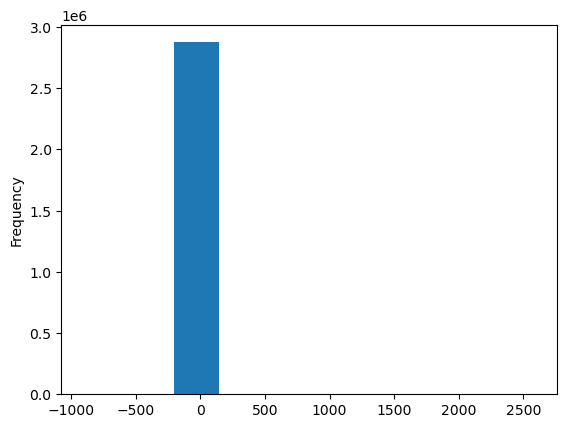

In [211]:
#sns.boxplot(x=df_for_analysis["payment_type"], y=df_for_analysis["fare_amount"])
df_for_analysis['fare_amount'].plot(kind="hist")

In [173]:
#Removing negative values from fare_amount and also 0 values from trip_distance/trip_duration_minutes values
taxi_df_prep = df_for_analysis[
    (df_for_analysis["fare_amount"]>=0)
    &(df_for_analysis["trip_distance"]>0)
    &(df_for_analysis["trip_duration_minutes"]>0)
    ].copy()
taxi_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2725881 entries, 0 to 2873792
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   trip_distance          float64       
 4   payment_type           int64         
 5   fare_amount            float64       
 6   extra                  float64       
 7   congestion_surcharge   float64       
 8   Airport_fee            float64       
 9   cbd_congestion_fee     float64       
 10  tip_amount             float64       
 11  trip_duration_minutes  float64       
 12  part_of_day            int64         
dtypes: datetime64[us](2), float64(8), int32(1), int64(2)
memory usage: 280.8 MB


In [174]:
#Skeweness check
skew_value_fare = taxi_df_prep['fare_amount'].skew()
skew_value_distanse = taxi_df_prep['trip_distance'].skew()
skew_value_duration = taxi_df_prep['trip_duration_minutes'].skew()
print(skew_value_fare)
print(skew_value_distanse)
print(skew_value_duration)

5.806693509090484
843.2614352070625
43.0865815053667


In [175]:
#Log transformation of skewed columns
taxi_df_prep['fare_log'] = np.log1p(taxi_df_prep['fare_amount'])
taxi_df_prep['distance_log'] = np.log1p(taxi_df_prep['trip_distance'])
taxi_df_prep['trip_duration_minutes_log'] = np.log1p(taxi_df_prep['trip_duration_minutes'])

In [177]:
print(f'fare {taxi_df_prep['fare_log'].skew()}')
print(f'distanse {taxi_df_prep['distance_log'].skew()}')
print(f'duration {taxi_df_prep['trip_duration_minutes_log'].skew()}')
#taxi_df_prep['distance_log'].plot(kind='hist')

fare 0.5923183186516374
distanse 1.096961895177794
duration 0.0884827302003472


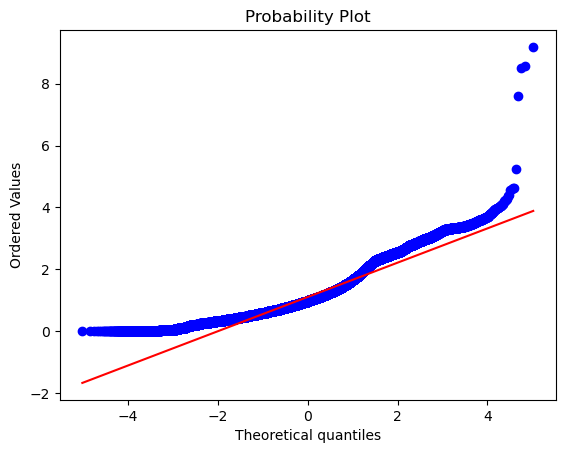

In [178]:
stats.probplot(taxi_df_prep['distance_log'], dist="norm", plot=plt)
plt.show()

In [179]:
#Removing outliers from fare_amount
std_taxi_fare = taxi_df_prep["fare_log"].std()
mean_taxi_fare = taxi_df_prep["fare_log"].mean()

lower_limit = mean_taxi_fare - 3*std_taxi_fare
upperl_limit = mean_taxi_fare + 3*std_taxi_fare

taxi_df_prep = taxi_df_prep[(taxi_df_prep["fare_log"]>lower_limit)&(taxi_df_prep["fare_log"]<upperl_limit)]


<Axes: ylabel='Frequency'>

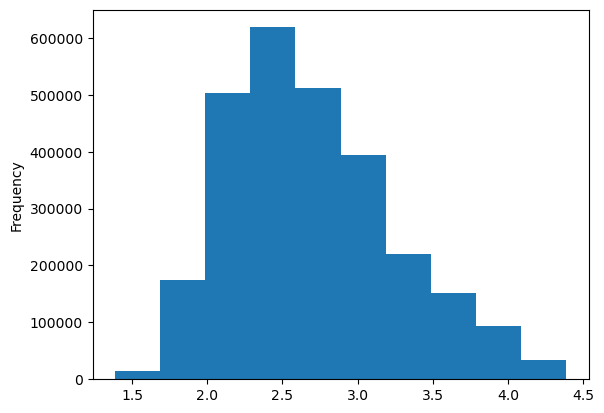

In [180]:
taxi_df_prep["fare_log"].plot(kind="hist")

In [181]:
#Removing outliers from trip_distance

Q1 = taxi_df_prep['trip_distance'].quantile(0.25)
Q3 = taxi_df_prep['trip_distance'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

taxi_df_prep = taxi_df_prep[(taxi_df_prep["distance_log"]>lower_limit)&(taxi_df_prep["distance_log"]<upperl_limit)]
taxi_df_prep['distance_log'].skew()

np.float64(1.0317950954569668)

<Axes: ylabel='Frequency'>

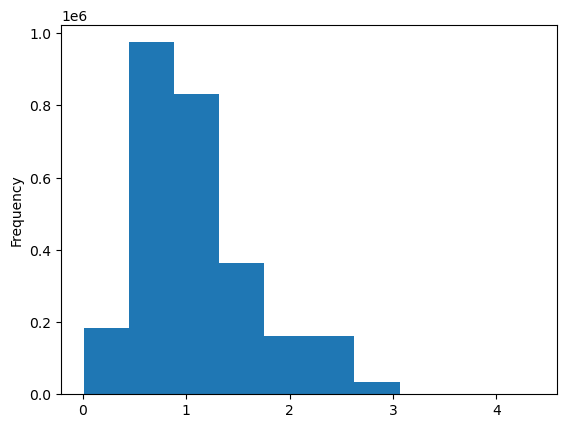

In [182]:
taxi_df_prep['distance_log'].plot(kind="hist")

In [183]:
#Removing outliers from trip_duration_minutes values
std_taxi_distance = taxi_df_prep["trip_duration_minutes_log"].std()
mean_taxi_distance  = taxi_df_prep["trip_duration_minutes_log"].mean()

lower_limit = mean_taxi_fare - 3*std_taxi_fare
upperl_limit = mean_taxi_fare + 3*std_taxi_fare

taxi_df_prep = taxi_df_prep[(taxi_df_prep["trip_duration_minutes_log"]>lower_limit)&(taxi_df_prep["trip_duration_minutes_log"]<upperl_limit)]
taxi_df_prep['trip_duration_minutes_log'].skew()

np.float64(0.030816398116403923)

<Axes: ylabel='Frequency'>

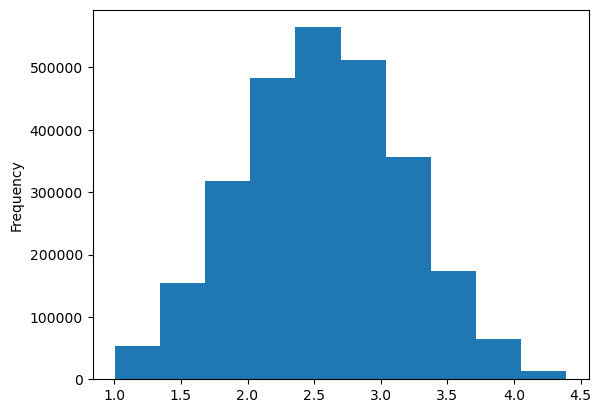

In [184]:
taxi_df_prep['trip_duration_minutes_log'].plot(kind="hist")

In [194]:
#Check tha amount of data removed
(taxi_df_prep.shape[0] / df_for_analysis.shape[0])-1

-0.06215722565960735

In [220]:
taxi_df_prep.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type,fare_amount,extra,congestion_surcharge,Airport_fee,cbd_congestion_fee,tip_amount,trip_duration_minutes,part_of_day,fare_log,distance_log,trip_duration_minutes_log
count,2695166.00,2695166,2695166,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00,2695166.00
mean,1.79,2025-06-15 21:54:15.141263,2025-06-15 22:08:50.290364,2.64,1.18,16.50,1.70,2.36,0.11,0.58,3.40,14.59,3.43,2.70,1.10,2.56
min,1.00,2025-05-31 22:34:26,2025-05-31 22:43:36,0.01,1.00,3.00,0.00,0.00,0.00,0.00,0.00,1.73,1.00,1.39,0.01,1.01
25%,2.00,2025-06-08 10:36:33,2025-06-08 10:50:17,1.00,1.00,8.60,0.00,2.50,0.00,0.75,1.50,7.47,3.00,2.26,0.69,2.14
50%,2.00,2025-06-15 17:22:50,2025-06-15 17:37:10.500000,1.64,1.00,12.80,1.00,2.50,0.00,0.75,3.00,11.98,3.00,2.62,0.97,2.56
75%,2.00,2025-06-23 14:14:10,2025-06-23 14:29:36.750000,2.90,1.00,19.80,2.50,2.50,0.00,0.75,4.43,18.85,4.00,3.03,1.36,2.99
max,2.00,2025-06-30 23:59:59,2025-07-01 00:39:11,78.25,5.00,79.30,12.50,2.50,1.75,0.75,960.94,79.68,5.00,4.39,4.37,4.39
std,0.41,NaN,NaN,2.82,0.49,11.60,1.94,0.57,0.43,0.31,3.20,10.06,1.16,0.54,0.56,0.61


In [222]:
taxi_df_prep.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'trip_distance', 'payment_type', 'fare_amount', 'extra',
       'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee',
       'tip_amount', 'trip_duration_minutes', 'part_of_day', 'fare_log',
       'distance_log', 'trip_duration_minutes_log'],
      dtype='object')

**Final Fare = (Flag-drop fee) + (Price per mile * distance traveled) + (Price per minute * time elapsed) + (Tolls & Surcharges)

<Axes: xlabel='part_of_day', ylabel='fare_log'>

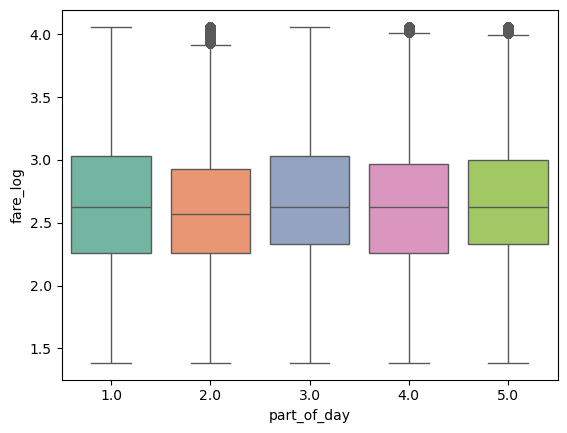

In [186]:
sns.boxplot(x=taxi_df_prep["part_of_day"], y=taxi_df_prep["fare_log"]
            , hue="part_of_day"
            , data=taxi_data_clean
            , palette="Set2"
            ,legend=False
           )

In [250]:
#date_time addition
taxi_df_prep["pickup_hour"] = taxi_df_prep["tpep_pickup_datetime"].dt.floor("h")
taxi_df_prep["trip_start_date"] = taxi_df_prep["tpep_pickup_datetime"].dt.day
taxi_df_prep["trip_start_hour"] = taxi_df_prep["tpep_pickup_datetime"].dt.hour
taxi_df_prep["day_of_week"] = taxi_df_prep["tpep_pickup_datetime"].dt.dayofweek

Text(0, 0.5, 'Trips count')

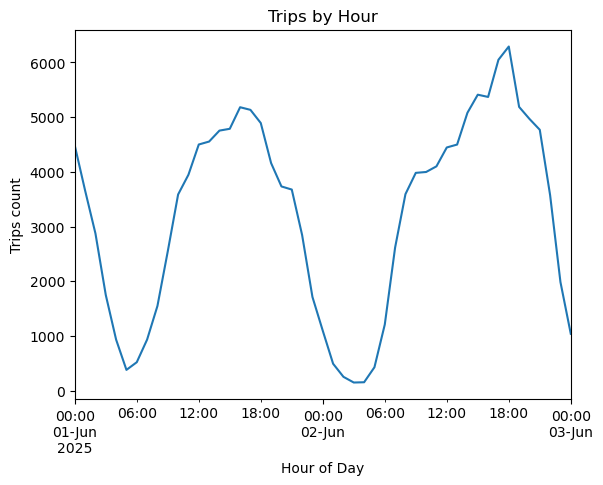

In [244]:
date_filter = taxi_df_prep["pickup_hour"].between('2025-06-01', '2025-06-03')
taxi_df_prep[date_filter].groupby("pickup_hour").size().plot(kind="line")
plt.title("Trips by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Trips count")

In [231]:
taxi_df_prep.size

45817822

Text(0, 0.5, 'Avg fare amount')

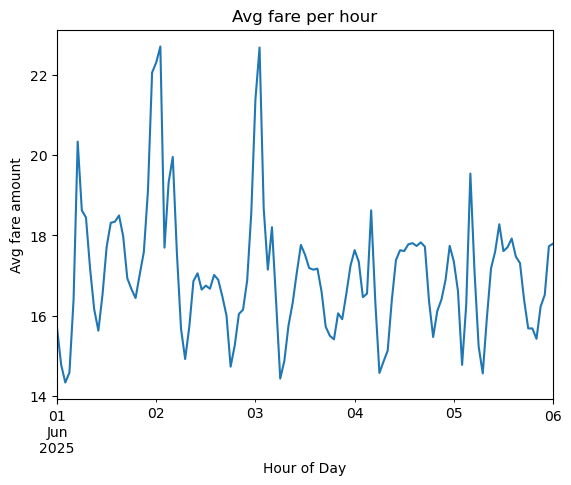

In [245]:
date_filter = taxi_df_prep["pickup_hour"].between('2025-06-01', '2025-06-06')

taxi_df_prep[date_filter].groupby("pickup_hour")["fare_amount"].mean().plot(kind="line")
plt.title("Avg fare per hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg fare amount")

Text(0, 0.5, 'Avg fare amount')

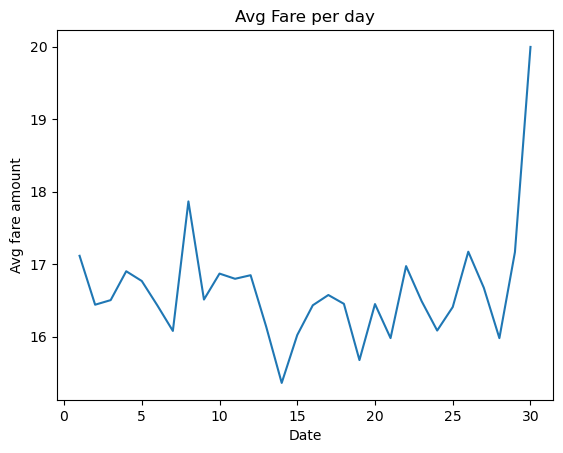

In [246]:
date_filter = taxi_df_prep["pickup_hour"].between('2025-06-01', '2025-06-30')
taxi_df_prep[date_filter].groupby("trip_start_date")["fare_amount"].mean().plot(kind="line")
plt.title("Avg Fare per day")
plt.xlabel("Date")
plt.ylabel("Avg fare amount")

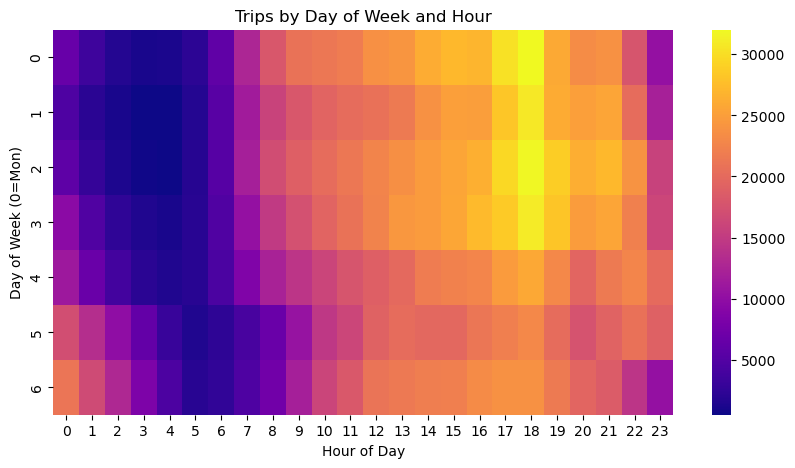

In [259]:
# Pivot table: rows=day of week, cols=hour
heatmap_data = taxi_df_prep.pivot_table(
    index="day_of_week",
    columns="trip_start_hour",
    values="VendorID",  # any column, just needs a count
    aggfunc="count"
)

plt.figure(figsize=(10,5))
sns.heatmap(heatmap_data, cmap="plasma")
plt.title("Trips by Day of Week and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon)")
plt.show()


Text(0, 0.5, 'Fare Amount ($)')

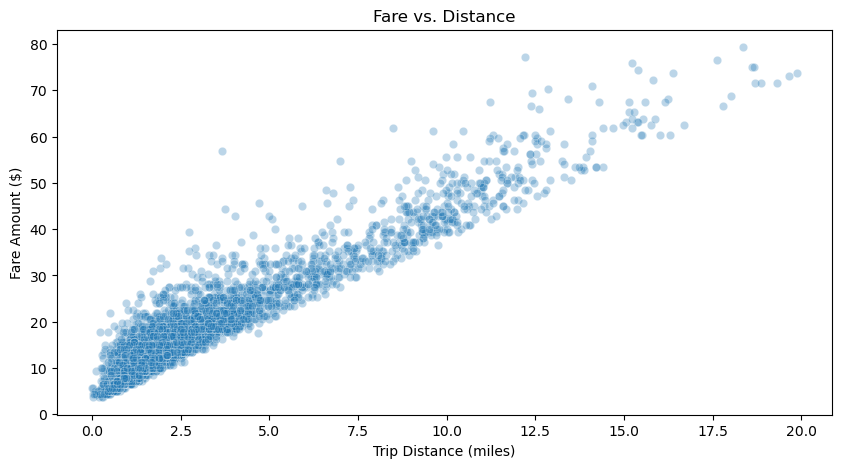

In [264]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=taxi_df_prep.sample(5000, random_state=23),  # sample to avoid overplotting
    x="trip_distance",
    y="fare_amount",
    alpha=0.3
)
plt.title("Fare vs. Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")